# One shot bike wheel detection
## Summary
We explore some ideas related to detecting the wheel of a bike.
A camera is placed on the bike frame, such that it is looking forward, with the front wheel in frame. A calibration target is attached to the frame, and is used as the "bike coordinates origin".

The broader context is the design of a visual odometry pipeline.

In that notebook, we look at detecting the front wheel in order to extract the yaw rate of the bike's trajectory.

We explore different ideas, but here we limit ourselves to using a single image, no prior information.

# Dataset
We collect our own images by using a GoPro camera and a bike. A few frames are then extracted from the video.
Since we are not interested in solving keypoint detection and matching here, we hand-annotate some of the relevant keypoints and save them to be reused.

In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pickle
import cv2 as cv
from scipy.optimize import differential_evolution


%matplotlib notebook

image_folder = "images/dataset2"
image_name = "sample3.jpg"
image_path = f"{image_folder}/{image_name}"

with open('../CameraCalibration/sensor_models/sensor_model_gopro_480.pkl', 'rb') as f:
    x = pickle.load(f)
    
K = x["intrinsics"]["camera_matrix"]
dist = x["distortion_coefficients"]

We use 3 frames from the videos, that correspond to the three main cases: positive wheel angle, negative wheel angle, and null angle (straight wheel).
For each frame, we save the points corresponding to the calibration target, as well as the wheel.

In [2]:
import os

# define bike frame here
origin = np.array([617, 233, 1])
ptX = np.array([620, 170, 1])
ptZ = np.array([594, 261, 1])
ptY = np.array([525, 226, 1])

# define wheel frame here
pt1 = np.array([399, 3, 1]) # front
pt2 = np.array([422, 216, 1]) # top
pt3 = np.array([212, 427, 1]) # back
pt4 = np.array([190, 209, 1]) # bottom
wheelO = np.array([279, 190,1])

if os.path.exists(f"{image_folder}/points.pkl"):
    with open(f"{image_folder}/points.pkl", "rb") as f:
        points_dict = pickle.load(f)
        if image_name in points_dict.keys():
            print("Reading point dump")
            locals().update(points_dict[image_name]["bike_frame"])
            locals().update(points_dict[image_name]["wheel_frame"])
        else:
            print("Adding image to dump")
            points_dict[image_name] = {}
            points_dict[image_name]["bike_frame"] = {"origin": origin, "ptX": ptX, "ptY": ptY, "ptZ": ptZ}
            points_dict[image_name]["wheel_frame"] = {"wheelO": wheelO, "pt1": pt1, "pt2": pt2, "pt3": pt3, "pt4": pt4}

            with open(f'{image_folder}/points.pkl', 'wb') as f:
                pickle.dump(points_dict, f)
else:    
    print("Creating point dump")
    points_dict = {}
    points_dict[image_name] = {}
    
    points_dict[image_name]["bike_frame"] = {"origin": origin, "ptX": ptX, "ptY": ptY, "ptZ": ptZ}
    points_dict[image_name]["wheel_frame"] = {"wheelO": wheelO, "pt1": pt1, "pt2": pt2, "pt3": pt3, "pt4": pt4}
    
    with open(f'{image_folder}/points.pkl', 'wb') as f:
        pickle.dump(points_dict, f)

Reading point dump


<IPython.core.display.Javascript object>


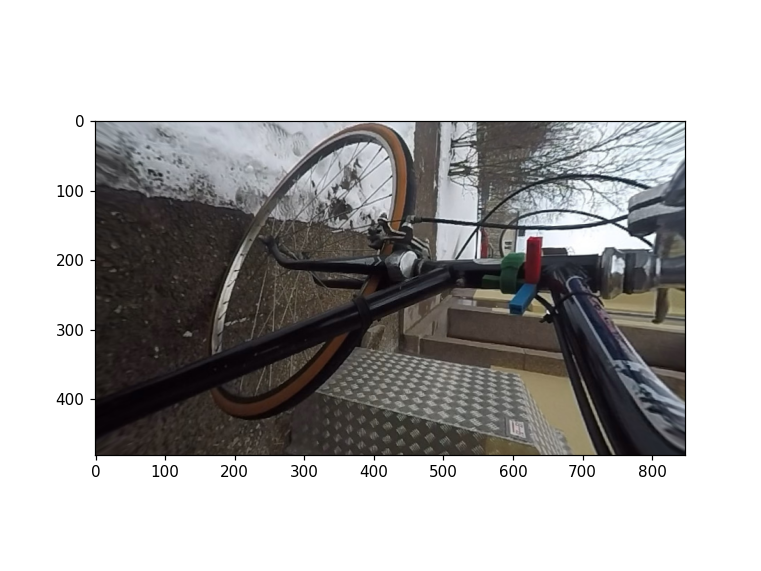

In [3]:
im = imread(f"{image_path}")
dst = cv.undistort(im, K, dist, None)

im = imread(f"{image_path}")
plt.figure()
plt.imshow(dst)

#dist = np.zeros(5)

# First Idea: using 3D frames
We compute the camera extrinsics using first the calibration target, then using the wheel points, since we know the wheel dimensions.


Problem with this approach: detecting the wheel is difficult.

<IPython.core.display.Javascript object>


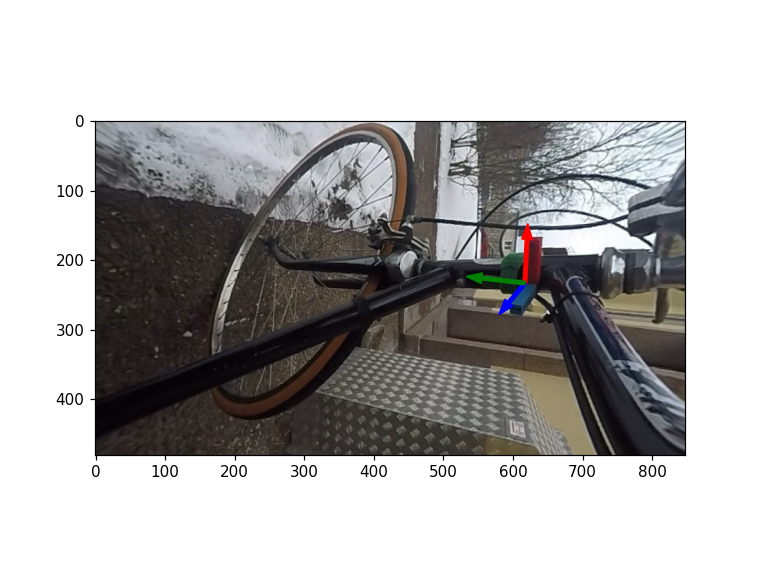

In [4]:
# First we plot our hand-annotated points that we will use to define the 3D frame.
# Define the bike frame origin
vecX = ptX - origin 
vecZ = ptZ - origin
vecY = ptY - origin

plt.figure()
plt.arrow(origin[0], origin[1], vecX[0], vecX[1],
          width = 5, color="red")
plt.arrow(origin[0], origin[1], vecZ[0], vecZ[1],
          width = 5, color="blue")
plt.arrow(origin[0], origin[1], vecY[0], vecY[1],
          width = 5, color="green")
plt.imshow(dst)

<IPython.core.display.Javascript object>


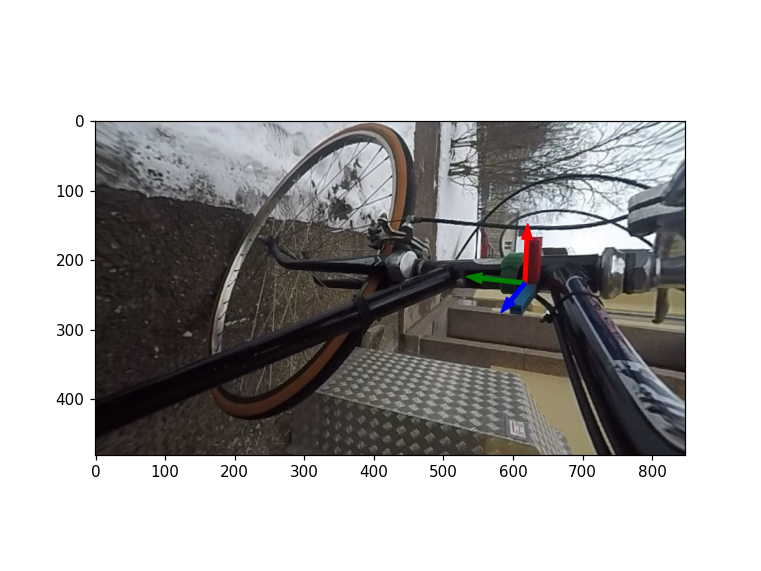

In [5]:
# Then we use solvePnP to compute the transformation from bike coordinates
# to the camera coordinates.
worldPoints = np.float32([[0, 0, 0], # origin
                        [4,0,0],
                        [0, 4, 0], # ptY
                        [0, 0, 4]]).reshape(-1, 3) # ptZ
imagePoints2 = np.float32([origin[:2],ptX[:2],ptY[:2], ptZ[:2]]).reshape(-1,2)


# R, t go from world to camera (camISO)
dist = np.zeros(5)
success, Rvec, tvec = cv.solvePnP(worldPoints, imagePoints2, K, dist, flags=cv.SOLVEPNP_AP3P)

R = cv.Rodrigues(Rvec)[0]
t = tvec
Rt = np.concatenate([R,t], axis=-1) # [R|t]


# Then as a sanity check we project some basis vectors expressed in bike coordinates
# onto the image by using the extrinsics and camera matrix
axis = np.float32([[0,0,0], [4,0,0], [0,4,0], [0,0,4]]).reshape(-1,3) # x y z
imgpts, _ = cv.projectPoints(axis, Rvec, tvec, K, dist)


plt.figure()
plt.imshow(dst)
origin2 = imgpts[0].ravel()
Xproj = imgpts[1].ravel()
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="red")
Xproj = imgpts[2].ravel() #y
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="green")
Xproj = imgpts[3].ravel() #y
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="blue")
plt.show()

<IPython.core.display.Javascript object>


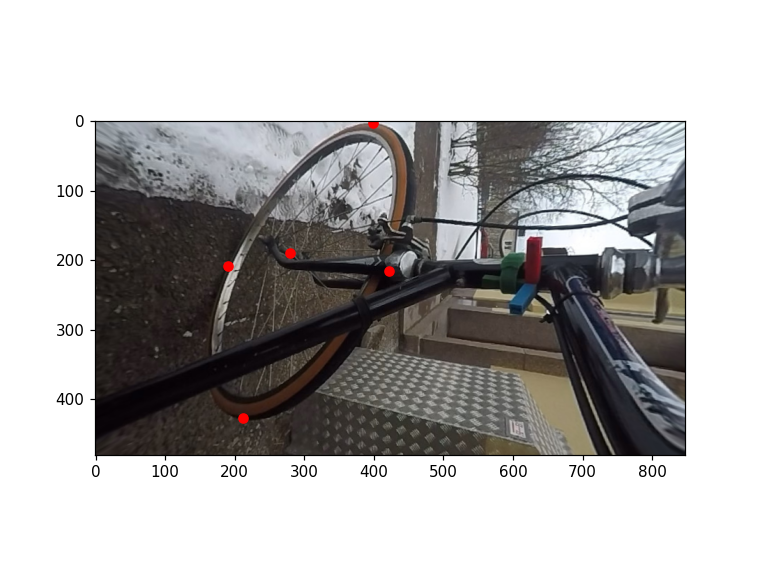

<IPython.core.display.Javascript object>


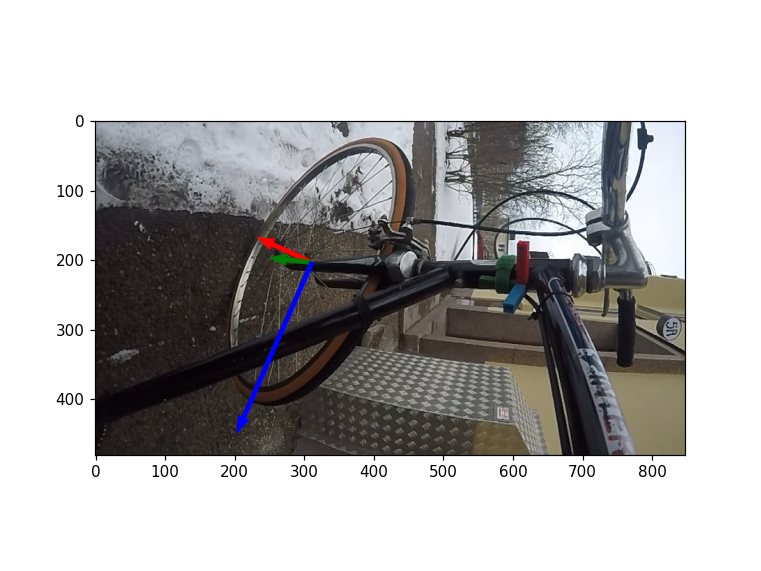

In [6]:
# Exact same operation is repeated for the wheel

from matplotlib import patches
fig = plt.figure()
plt.imshow(dst)

# fake wheel
for p in [pt1, pt2, pt3, pt4, wheelO]:
    plt.scatter(p[0], p[1], c="r")
    
plt.show()


# Compute transform form wheel coordinates to camera coordinates
worldPoints = np.float32([[0, 0, -40], # front pt1
                        [0, -40, 0], # pt2
                        [0, 0, 40], # pt3 back
                        [0, 40, 0]]).reshape(-1, 3) # ptZ
imagePoints2 = np.float32([pt1[:2],pt2[:2],pt3[:2], pt4[:2]]).reshape(-1,2)

success2, Rvec2, tvec2 = cv.solvePnP(worldPoints, imagePoints2, K, dist, flags=cv.SOLVEPNP_P3P)


axis = np.float32([[0,0,0], [10,0,0], [0,40,0], [0,0,40]]).reshape(-1,3) # x y z
imgpts, jac = cv.projectPoints(axis, Rvec2, tvec2, K, dist)


plt.figure()
plt.imshow(im)
origin2 = imgpts[0].ravel()
Xproj = imgpts[1].ravel()
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="red")
Xproj = imgpts[2].ravel() #y
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="green")
Xproj = imgpts[3].ravel() #y
plt.arrow(origin2[0], origin2[1], Xproj[0] - origin2[0], Xproj[1] - origin2[1],
          width = 5, color="blue")
plt.show()

Now that we have two frames, we can align them. In particular, we are interested in the yaw (the y component).

In [7]:
from scipy.spatial.transform import Rotation as Rot
Rworld = Rot.from_rotvec(Rvec.squeeze()).as_matrix()
Rwheel = Rot.from_rotvec(Rvec2.squeeze()).as_matrix()

Rot.from_matrix(Rworld.T @ Rwheel).as_euler("xyz", degrees = True)

array([-27.94073658, -43.83155929,  29.32160564])

# Second idea: computing a 2D homography
We consider two planes: one for the bike frame and one for the wheel. We then compute a homography to align them.

All in all this solution is similar to the first one, but with the advantage that we do not need to know the wheel dimensions. There is still however the problem that one needs to obtain keypoints lying on the wheel.

<IPython.core.display.Javascript object>


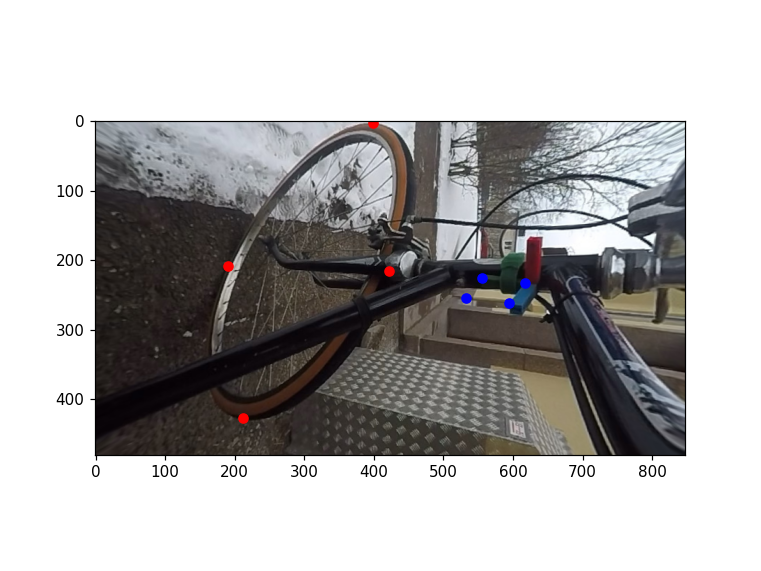

In [8]:
# Homography
# Define the bike frame origin
ptFourth = ptY + vecZ

fig = plt.figure()
ax = fig.add_subplot(111)
for p in [origin, ptY, ptZ, ptFourth]:
    ax.scatter(p[0], p[1], c="b")
    
for p in [pt1, pt2, pt3, pt4]:
    plt.scatter(p[0], p[1], c="r")

ax.imshow(dst)
plt.show()

We can then decompose the homography. 

Remark: be mindfull of associating the points from each plane in the correct order. Here for instance we map the front of the wheel to the origin of the target, the top to the Z axis and the bottom to the Y axis. As such there is a 45 degrees rotation along the Z axis between the two planes.

In [9]:
H, _ = cv.findHomography(np.array([origin, ptZ, ptFourth, ptY]), np.array([pt1, pt2, pt3, pt4])) # front top  back bottom
_, RvecH, TvecH, nvec = cv.decomposeHomographyMat(H, K)


from scipy.spatial.transform import Rotation as Rot

for R in RvecH:
    print(Rot.from_matrix(R).as_euler("yxz", degrees = True))

[-41.65560427 -23.85039363 -45.77006775]
[-41.65560427 -23.85039363 -45.77006775]
[  2.720121    27.13733983 -51.40459528]
[  2.720121    27.13733983 -51.40459528]


# Optimization idea
## Principle
We try to solve the issue of needing to detect the wheel. 
Using naive approaches such as Canny + ellipse detection is not robust enough. 
If we had a sequence of images we could use background substraction to help, but we chose to limit ourselves to a single image.

Therefore, we decide to explore the idea of using a strong prior to guide the detection.
Using the extrinsics, we project a circle where the wheel should be, and then try to rotate it such that it fits the wheel in the image.

Steps:
1. Calibrate camera using the target on the frame
2. Generate a 2D circle
3. Project it in 3D, translating and rotating it according to the calibration
4. Compute the gradient in the image under that circle
5. Rotate a bit the circle to minimize the gradient.

Remarks:
- We need to remove the sampling points that fall outside the image.

In [10]:
# Parameters
wheel_width = 31
wheel_y_translation_from_handlebar = 50
nb_wheel_sample_points = 500

<IPython.core.display.Javascript object>


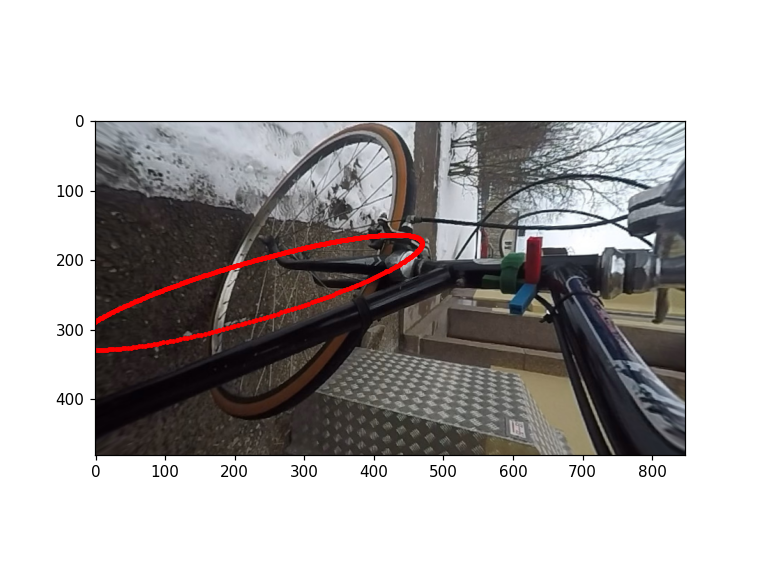

In [11]:
# Circle projection
import math
# https://gis.stackexchange.com/questions/76745/creating-a-circle-with-points
# Two dimensional rotation
# returns coordinates in a tuple (x,y)
def rotate(x, y, r):
    rx = (x*math.cos(r)) - (y*math.sin(r))
    ry = (y*math.cos(r)) + (x*math.sin(r))
    return (rx, ry)

# create a ring of points centered on center (x,y) with a given radius
# using the specified number of points
# center should be a tuple or list of coordinates (x,y)
# returns a list of point coordinates in tuples
# ie. [(x1,y1),(x2,y2
def point_ring(center, num_points, radius):
    arc = (2 * math.pi) / num_points # what is the angle between two of the points
    points = []
    for p in range(num_points):
        (px,py) = rotate(0, radius, arc * p) 
        px += center[0]
        py += center[1]
        points.append((px,py))
    return points 

# Create circle and make it 3D
circle = point_ring((0,wheel_y_translation_from_handlebar),
                    nb_wheel_sample_points,
                    wheel_width)

circle = np.float32(circle)
circle = np.c_[circle, np.zeros(circle.shape[0])]

# Rotate it in 3D
rot_along_y = Rot.from_euler("y", 90, degrees = True).as_matrix()
circle = circle @ rot_along_y.T

rot_along_y = Rot.from_euler("xzy", [-3, 5, 0], degrees = True).as_matrix() #-3,5,0 #-10,6
circle = circle @ rot_along_y.T

# Project the circle by using the camera calibration
imgpts, _ = cv.projectPoints(circle, Rvec, tvec, K, dist)

plt.figure()
plt.scatter(*imgpts.T, s=5, c="red")
plt.imshow(dst)
plt.show()

In [17]:
# Full translation sweep around the y axis
degrees = 360

# For each rotation...
## Contains the nb_wheel_sample_points pixels under the circles 
wheel_slices = [None for x in range(0, degrees)]
## Contains the sampling points (used for visualization)
slices_pts = [None for  x in range(len(wheel_slices))]
## 
clipped_pixels = np.empty((degrees, nb_wheel_sample_points))

for deg in range(0, degrees):
    rot_along_y = Rot.from_euler("y", deg, degrees = True).as_matrix()
    circle_rot = circle @ rot_along_y.T

    # Project the circle by reusing previous stuff
    imgpts, _ = cv.projectPoints(circle_rot, Rvec, tvec, K, dist)
    imgpts_int = imgpts.astype(int)
    imgpts_int = imgpts_int.squeeze()
    
    imgpts_int_clipped = np.empty_like(imgpts_int)
    imgpts_int_clipped[:, 0] = np.clip(imgpts_int[:, 0], 0, dst.shape[1] - 1)
    imgpts_int_clipped[:, 1] = np.clip(imgpts_int[:, 1], 0, dst.shape[0] - 1)
    # Save the sampling points
    slices_pts[deg] = imgpts_int_clipped  
    
    # Sample the image and color the invalid areas (due to clipping) in green
    wheel_slice = dst[imgpts_int_clipped[:,1], imgpts_int_clipped[:,0], :]
    clipped_pixels_in_slice = ((imgpts_int[:,0] < 0)
                      | (imgpts_int[:, 1] < 0)
                      | (imgpts_int[:,0] > dst.shape[0] - 1)
                      | (imgpts_int[:, 1] > dst.shape[1] - 1))
    clipped_pixels[deg] = clipped_pixels_in_slice
    wheel_slice[clipped_pixels_in_slice] = [0,255,0]
                      
    wheel_slices[deg] = wheel_slice

wheel_slices = np.array(wheel_slices)
slices_pts = np.array(slices_pts)
clipped_pixels = clipped_pixels.astype(bool)

wheel_slices_norm = np.linalg.norm(wheel_slices, axis = 2)
wheel_slices_diff = np.abs(np.diff(wheel_slices_norm, n = 1, axis=1, append = 0))

In [19]:
mean_of_norm = np.empty((wheel_slices.shape[0]))

for d in range(wheel_slices.shape[0]):
    wheel_slice = wheel_slices[d]
    clipped_pixels_in_slice = clipped_pixels[d]
    mean_of_norm[d] = np.abs(
                np.diff(
                    np.linalg.norm(wheel_slice[~clipped_pixels_in_slice], axis = 1)
                )
            ).mean()

<IPython.core.display.Javascript object>


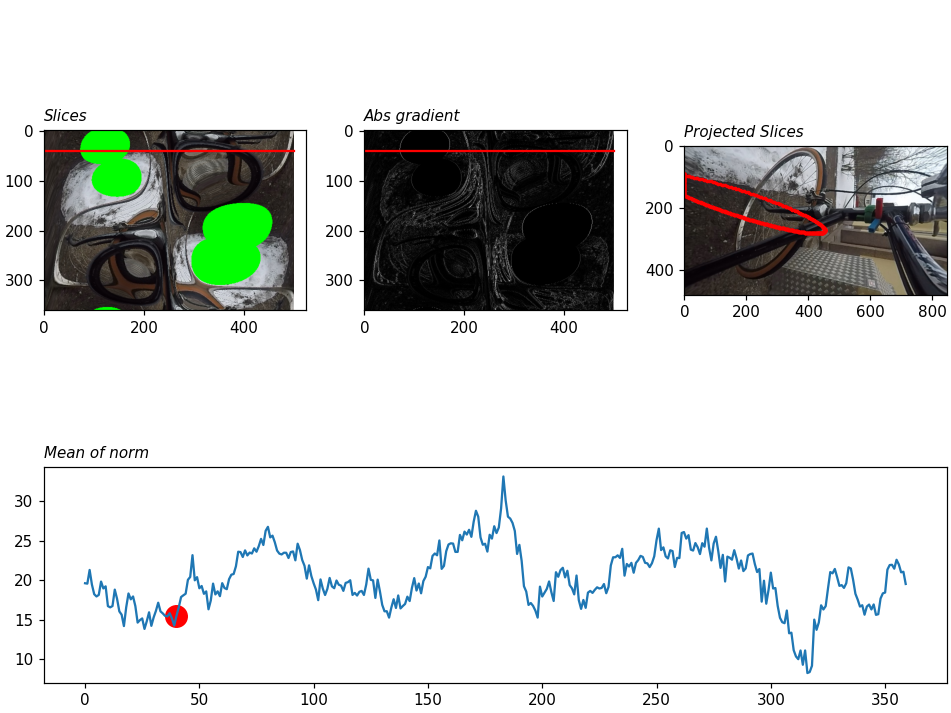

In [20]:
d = 40

gs_kw = dict(width_ratios=[1, 1, 1], height_ratios=[2, 1])
f, ax = plt.subplot_mosaic([["Slices", "Abs gradient", "Projected Slices"],
                            ["Mean of norm", "Mean of norm", "Mean of norm"]],
                            constrained_layout=True,
                            gridspec_kw=gs_kw,
                            figsize = (8, 6))

for label, a in ax.items():
    a.set_title(label, loc='left', fontsize='medium', fontstyle = "italic")

ax["Slices"].imshow(wheel_slices)
ax["Slices"].plot([0, wheel_slices.shape[1]], [d, d], c = "r")

ax["Abs gradient"].imshow(wheel_slices_diff, cmap = "gray")
ax["Abs gradient"].plot([0, wheel_slices.shape[1]], [d, d], c = "r")

ax["Mean of norm"].plot([x for x in range(wheel_slices_diff.shape[0])], mean_of_norm)
ax["Mean of norm"].scatter(x = d , y = mean_of_norm[d], s= 200, c = "r")

ax["Projected Slices"].imshow(dst)
ax["Projected Slices"].scatter(*slices_pts[d].T, s = 2, c = "r")
plt.show()

In [21]:
# Expressed as an optimization problem
def wheel_err(angles, circle, projectFunc, dst):
    rot_along_y = Rot.from_euler("xyz", angles, degrees = True).as_matrix()
    circle_rot = circle @ rot_along_y.T
    imgpts, _ = projectFunc(circle_rot)
    
    imgpts_int = imgpts.astype(int)
    imgpts_int = imgpts_int.squeeze()
    
    imgpts_int_clipped = np.empty_like(imgpts_int)
    imgpts_int_clipped[:, 0] = np.clip(imgpts_int[:, 0], 0, dst.shape[1] - 1)
    imgpts_int_clipped[:, 1] = np.clip(imgpts_int[:, 1], 0, dst.shape[0] - 1)
     
    # Sample the image and color the invalid areas (due to clipping) in green
    wheel_slice = dst[imgpts_int_clipped[:,1], imgpts_int_clipped[:,0], :]
    clipped_pixels_in_slice = ((imgpts_int[:,0] < 0)
                      | (imgpts_int[:, 1] < 0)
                      | (imgpts_int[:,0] > dst.shape[0] - 1)
                      | (imgpts_int[:, 1] > dst.shape[1] - 1))

    return np.abs(
                np.diff(
                    np.linalg.norm(wheel_slice[~clipped_pixels_in_slice], axis = 1)
                )
            ).mean()

projectFunc = lambda x: cv.projectPoints(x, Rvec, tvec, K, dist)

wheel_err([0, 43.40532484, 0], circle, projectFunc, dst)

18.426290819815822

In [33]:
x0 = [0, 0, 0]
res = differential_evolution(func = lambda x: wheel_err(x, circle, projectFunc, dst),
                             x0 = x0,
                             bounds = [(-2, 2), (-90, 90), (-2, 2)],
                             )

res.x

array([  0.22912814, -44.10712529,   0.17728757])

<IPython.core.display.Javascript object>


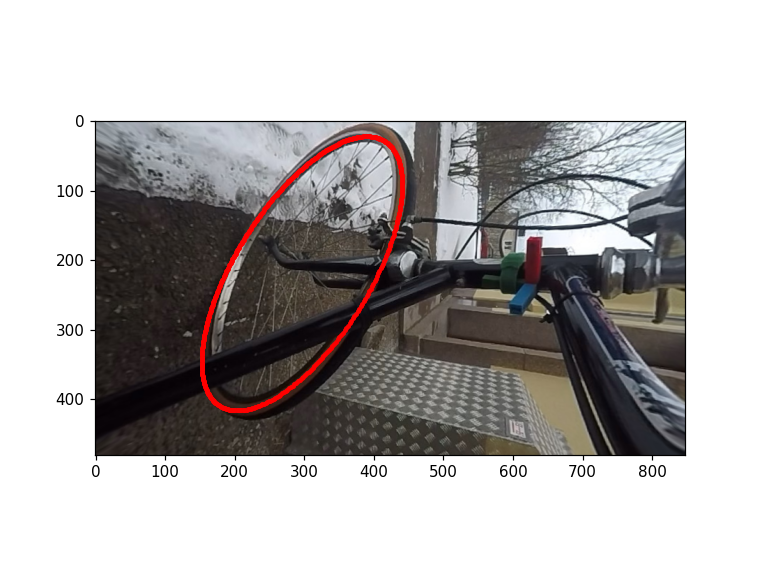

In [34]:
rot_along_y = Rot.from_euler("xyz", res.x, degrees = True).as_matrix() 
circle1 = circle @ rot_along_y.T

# Project the circle by using the camera calibration
imgpts, _ = cv.projectPoints(circle1, Rvec, tvec, K, dist)

plt.figure()
plt.scatter(*imgpts.T, s=5, c="red")
plt.imshow(dst)
plt.show()